#   **Amazon Fine Food Reviews Analysis- sentimental analysis using Decision Trees**

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
Number of reviews: 568,454 
Number of users: 256,059 
Number of products: 74,258 
Timespan: Oct 1999 - Oct 2012 
Number of Attributes/Columns in data: 10 Attribute Information: 
                                  1) Id 
                                  2) ProductId - unique identifier for the product 
                                  3) UserId - unqiue identifier for the user
                                  4) ProfileName 
                                  5) HelpfulnessNumerator - number of users who found the review helpful 
                                  6) HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not                                     7) Score - rating between 1 and 5 
                                  8) Time - timestamp for the review 9) Summary - brief summary of the review 10) Text - text of the review **Objective:**
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review. 

**Loading the data**
The dataset is available in two forms 1).csv file 2)SQLite Database In order to load the data, 
We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

we will make postive label as 1 and negative score as 0 becoz we are taking log loss as metric.

**Exploratory Data Analysis**

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import sqlite3

import gensim
%matplotlib inline
import pandas as pd
import numpy as np
import sqlite3
import re
import nltk
import matplotlib.pyplot as plt
from  nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score,log_loss
import warnings
warnings.filterwarnings('ignore')
import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

['database.sqlite', 'hashes.txt', 'Reviews.csv']


In [10]:
con = sqlite3.connect(r'../input/database.sqlite')
data = pd.read_sql_query('select * from REVIEWS where Score!=3',con)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [11]:
#changing reviews score to 1(postive) if score is > 3 and 0(negative) if score less than 3

def change_labels(x):
    if x > 3:
        return 1
    return 0
temp_score = data['Score']
temp_score = temp_score.map(change_labels)
data['Score'] =  temp_score
data['Score'].head()

0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64

In [12]:
#Removing Duplicates
print('Number of data points before removing duplicates',data.shape[0])
sorted_data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
clean_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print('Number of data points after removing duplicates',clean_data.shape[0])

Number of data points before removing duplicates 525814
Number of data points after removing duplicates 364173


In [13]:
#removing rows whihch has HelpfulnessNumerator greater than HelpfulnessDenominator
clean_data=clean_data[clean_data['HelpfulnessNumerator']<=clean_data['HelpfulnessDenominator']]
print('Now the Number of data points are',clean_data.shape[0])



Now the Number of data points are 364171


**Text Preprocessing: Stemming, stop-word removal and Lemmatization.**
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.
Hence in the Preprocessing phase we do the following in the order below:-
 1) Begin by removing the html tags
 2) Remove any punctuations or limited set of special characters like , or . or # etc.
 3) Check if the word is made up of english letters and is not alpha-numeric
 4) Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
 5) Convert the word to lowercase
 6) Remove Stopwords
 7) Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [14]:
#lets define some functions to  clean the reviews

#to remove HTML Tags
def clean_html(x):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', x)
    return cleantext
#  to remove unwanted charecteres like '!',',' etc.

def cleansen(x):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',x)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

#stop words

stop_words = set(stopwords.words('english'))
#intialising stremming
stemmer = nltk.stem.SnowballStemmer('english')

In [15]:
import datetime

str1=' '
final_string=[]

s=''
start_time = date
time.datetime.now()
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    sent=clean_html(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleansen(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop_words):
                    s=(stemmer.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
clean_data['CleanedText']=final_string
print('Total time taken to clean the reviews',datetime.datetime.now()-start_time)

Total time taken to clean the reviews 0:04:44.859867


In [16]:
clean_data['CleanedText'].head()

138706    b'witti littl book make son laugh loud recit c...
138688    b'grew read sendak book watch realli rosi movi...
138689    b'fun way children learn month year learn poem...
138690    b'great littl book read nice rhythm well good ...
138691    b'book poetri month year goe month cute littl ...
Name: CleanedText, dtype: object

In [17]:

data_pos = clean_data[clean_data["Score"] == 1].sample(n = 50000)
data_neg = clean_data[clean_data["Score"] == 0].sample(n = 50000)
final_data = pd.concat([data_pos, data_neg])
final_data.shape

(100000, 11)

Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively****

In [18]:
from sklearn.model_selection import train_test_split
X,X_test,Y,Y_test = train_test_split(final_data['CleanedText'],final_data['Score'],test_size=0.2)
X_train,X_cv,Y_train,Y_cv = train_test_split(X,Y,test_size=0.2)


**Bag of Words (BoW)**
A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.

In [19]:
#Lets Vecotirize
#bagof words
bag_words = CountVectorizer()
X_train_bag = bag_words.fit_transform(X_train)
X_test_bag = bag_words.transform(X_test)
X_cv_bag = bag_words.transform(X_cv)
print('After vectorizing shape of x Train',X_train_bag.shape)
print('After vectorizing shape of x Test',X_test_bag.shape)
print('After vectorizing shape of x CV',X_cv_bag.shape)

After vectorizing shape of x Train (64000, 31263)
After vectorizing shape of x Test (20000, 31263)
After vectorizing shape of x CV (16000, 31263)


>                                     **Decision Trees **

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss,accuracy_score,confusion_matrix,classification_report
import seaborn as sns
#defining DT function
def decision_treegini(x_train,y_train,x_test,y_test,x_cv,y_cv,depth):
    cv_log_error =[]
    train_log_error=[]
    for i in depth:
        clf_dt = DecisionTreeClassifier(max_depth =i)
        clf_dt.fit(x_train,y_train)
        predict_ytrain = clf_dt.predict(x_train)
        predict_y = clf_dt.predict(x_cv)
        f1score_train = f1_score(y_train,predict_ytrain)
        f1score_cv = f1_score(y_cv,predict_y)
        train_log_error.append(f1score_train)
        print('The f1 score of cv data for depth ',i,'is',f1score_cv)
        cv_log_error.append(f1score_cv)
    fig, ax = plt.subplots()
    ax.plot(depth, cv_log_error,c='g',label='CV_f1 score')
    for i, txt in enumerate(np.round(cv_log_error,3)):
        ax.annotate((depth[i],np.round(txt,3)), (depth[i],cv_log_error[i]))
    ax.plot(depth, train_log_error,c='b',label='Train_f1 score')
    for i, txt in enumerate(np.round(train_log_error,3)):
        ax.annotate((depth[i],np.round(txt,3)), (depth[i],train_log_error[i]))
    
    plt.grid()
    plt.title("F1 score for each depth ")
    plt.xlabel("Depth values's",)
    plt.ylabel("f1 score")
    plt.legend()
    plt.show()
    

In [48]:
def best_model(x_train,y_train,x_test,y_test,x_cv,y_cv,bestdepth):
    
    
    clf_dt_best = DecisionTreeClassifier(max_depth = bestdepth)
    clf_dt_best.fit(x_train, y_train)
    predict_y_train = clf_dt_best.predict(x_train)
    print('For values of best depth = ', bestdepth, "The train f1  score is:",f1_score(y_train,predict_y_train))
    predict_y_test = clf_dt_best.predict(x_test)
    print('For values of  best depth = ', bestdepth, "The test  f1 score is:",f1_score(y_test,predict_y_test))
    acc_t = accuracy_score(y_train,predict_y_train)
    print('Accuracy on train data is ',acc_t)
    
    acc = accuracy_score(y_test,predict_y_test)
    print('Accuracy on test data is ',acc)
    c_1 = confusion_matrix(y_train, predict_y_train)
    C = confusion_matrix(y_test, predict_y_test)
    print("-"*20, "Confusion matrix on train data", "-"*20)
    plt.figure(figsize=(20,7))
    
    sns.heatmap(c_1, annot=True, cmap="YlGnBu", fmt="d")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*20, "Confusion matrix on test data", "-"*20)
    plt.figure(figsize=(20,7))
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="d")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print(classification_report(y_test, predict_y_test))
    return acc,bestdepth

The f1 score of cv data for depth  5 is 0.6542082536985914
The f1 score of cv data for depth  10 is 0.740637159533074
The f1 score of cv data for depth  20 is 0.7607758620689656
The f1 score of cv data for depth  40 is 0.764769065520945
The f1 score of cv data for depth  80 is 0.7573552279654163
The f1 score of cv data for depth  160 is 0.7494440326167531
The f1 score of cv data for depth  200 is 0.7484104226405686
The f1 score of cv data for depth  250 is 0.7524629006110488


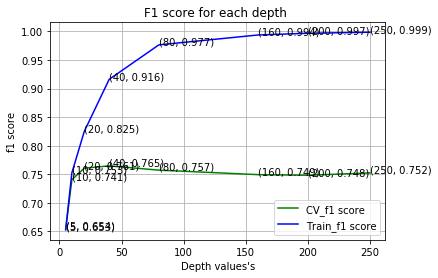

In [46]:
#differernt depth
depth = [5,10,20,40,80,160,200,250]
decision_treegini(X_train_bag,Y_train,X_test_bag,Y_test,X_cv_bag,Y_cv,depth)

From seeing above plot we can say that  10 is the best depth as there is not much difference in train and cross validata f1_score. so considering 10 as best depth for bag of words

For values of best depth =  10 The train f1  score is: 0.7527615184894992
For values of  best depth =  10 The test  f1 score is: 0.7369657805845206
Accuracy on train data is  0.748546875
Accuracy on test data is  0.73135
-------------------- Confusion matrix on train data --------------------


<Figure size 1440x504 with 0 Axes>

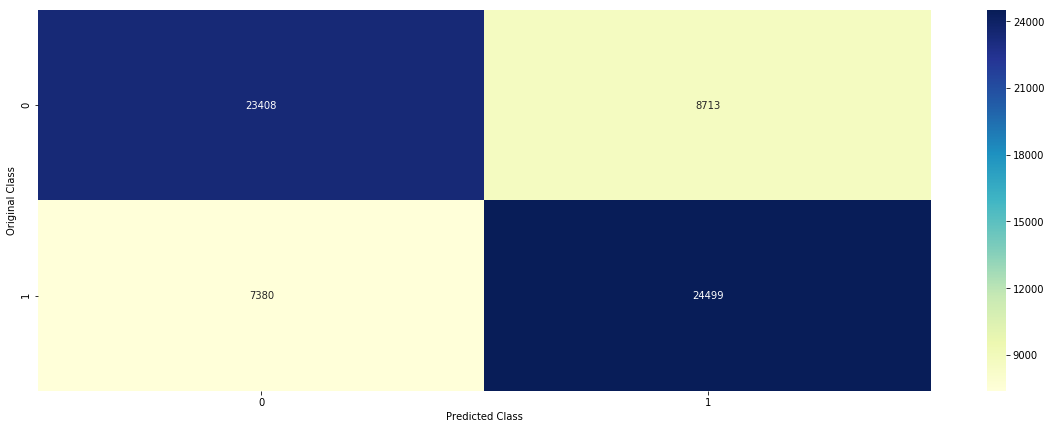

-------------------- Confusion matrix on test data --------------------


<Figure size 1440x504 with 0 Axes>

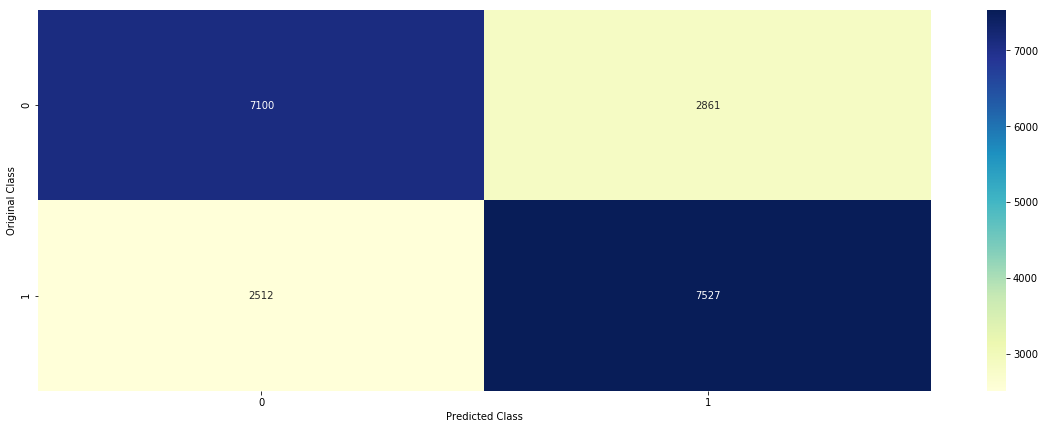

              precision    recall  f1-score   support

           0       0.74      0.71      0.73      9961
           1       0.72      0.75      0.74     10039

   micro avg       0.73      0.73      0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000



In [49]:
acc_bag,best_depth = best_model(X_train_bag,Y_train,X_test_bag,Y_test,X_cv_bag,Y_cv,10)

We can see best max_depth is 10 and accuracy on test_data is 73.15% and model is good as it is not underfit or over fit because there is not much diffrence in train and test accuracy .Lets print top 25 import features

In [51]:
#feature importance

clf = DecisionTreeClassifier(max_depth = 10)
clf.fit(X_train_bag,Y_train)
importances = clf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]
names = bag_words.get_feature_names()
names = np.array(names)
print('Top 25 important features',names[indices])



Top 25 important features ['great' 'disappoint' 'love' 'best' 'delici' 'bad' 'perfect' 'excel'
 'good' 'favorit' 'would' 'tasti' 'thought' 'unfortun' 'review' 'money'
 'tast' 'return' 'worst' 'wast' 'howev' 'date' 'hope' 'threw' 'horribl']


Lets try to see the decision tree .Here we are visualizing only upto 3 depths as more than that we cannt see the tree properly

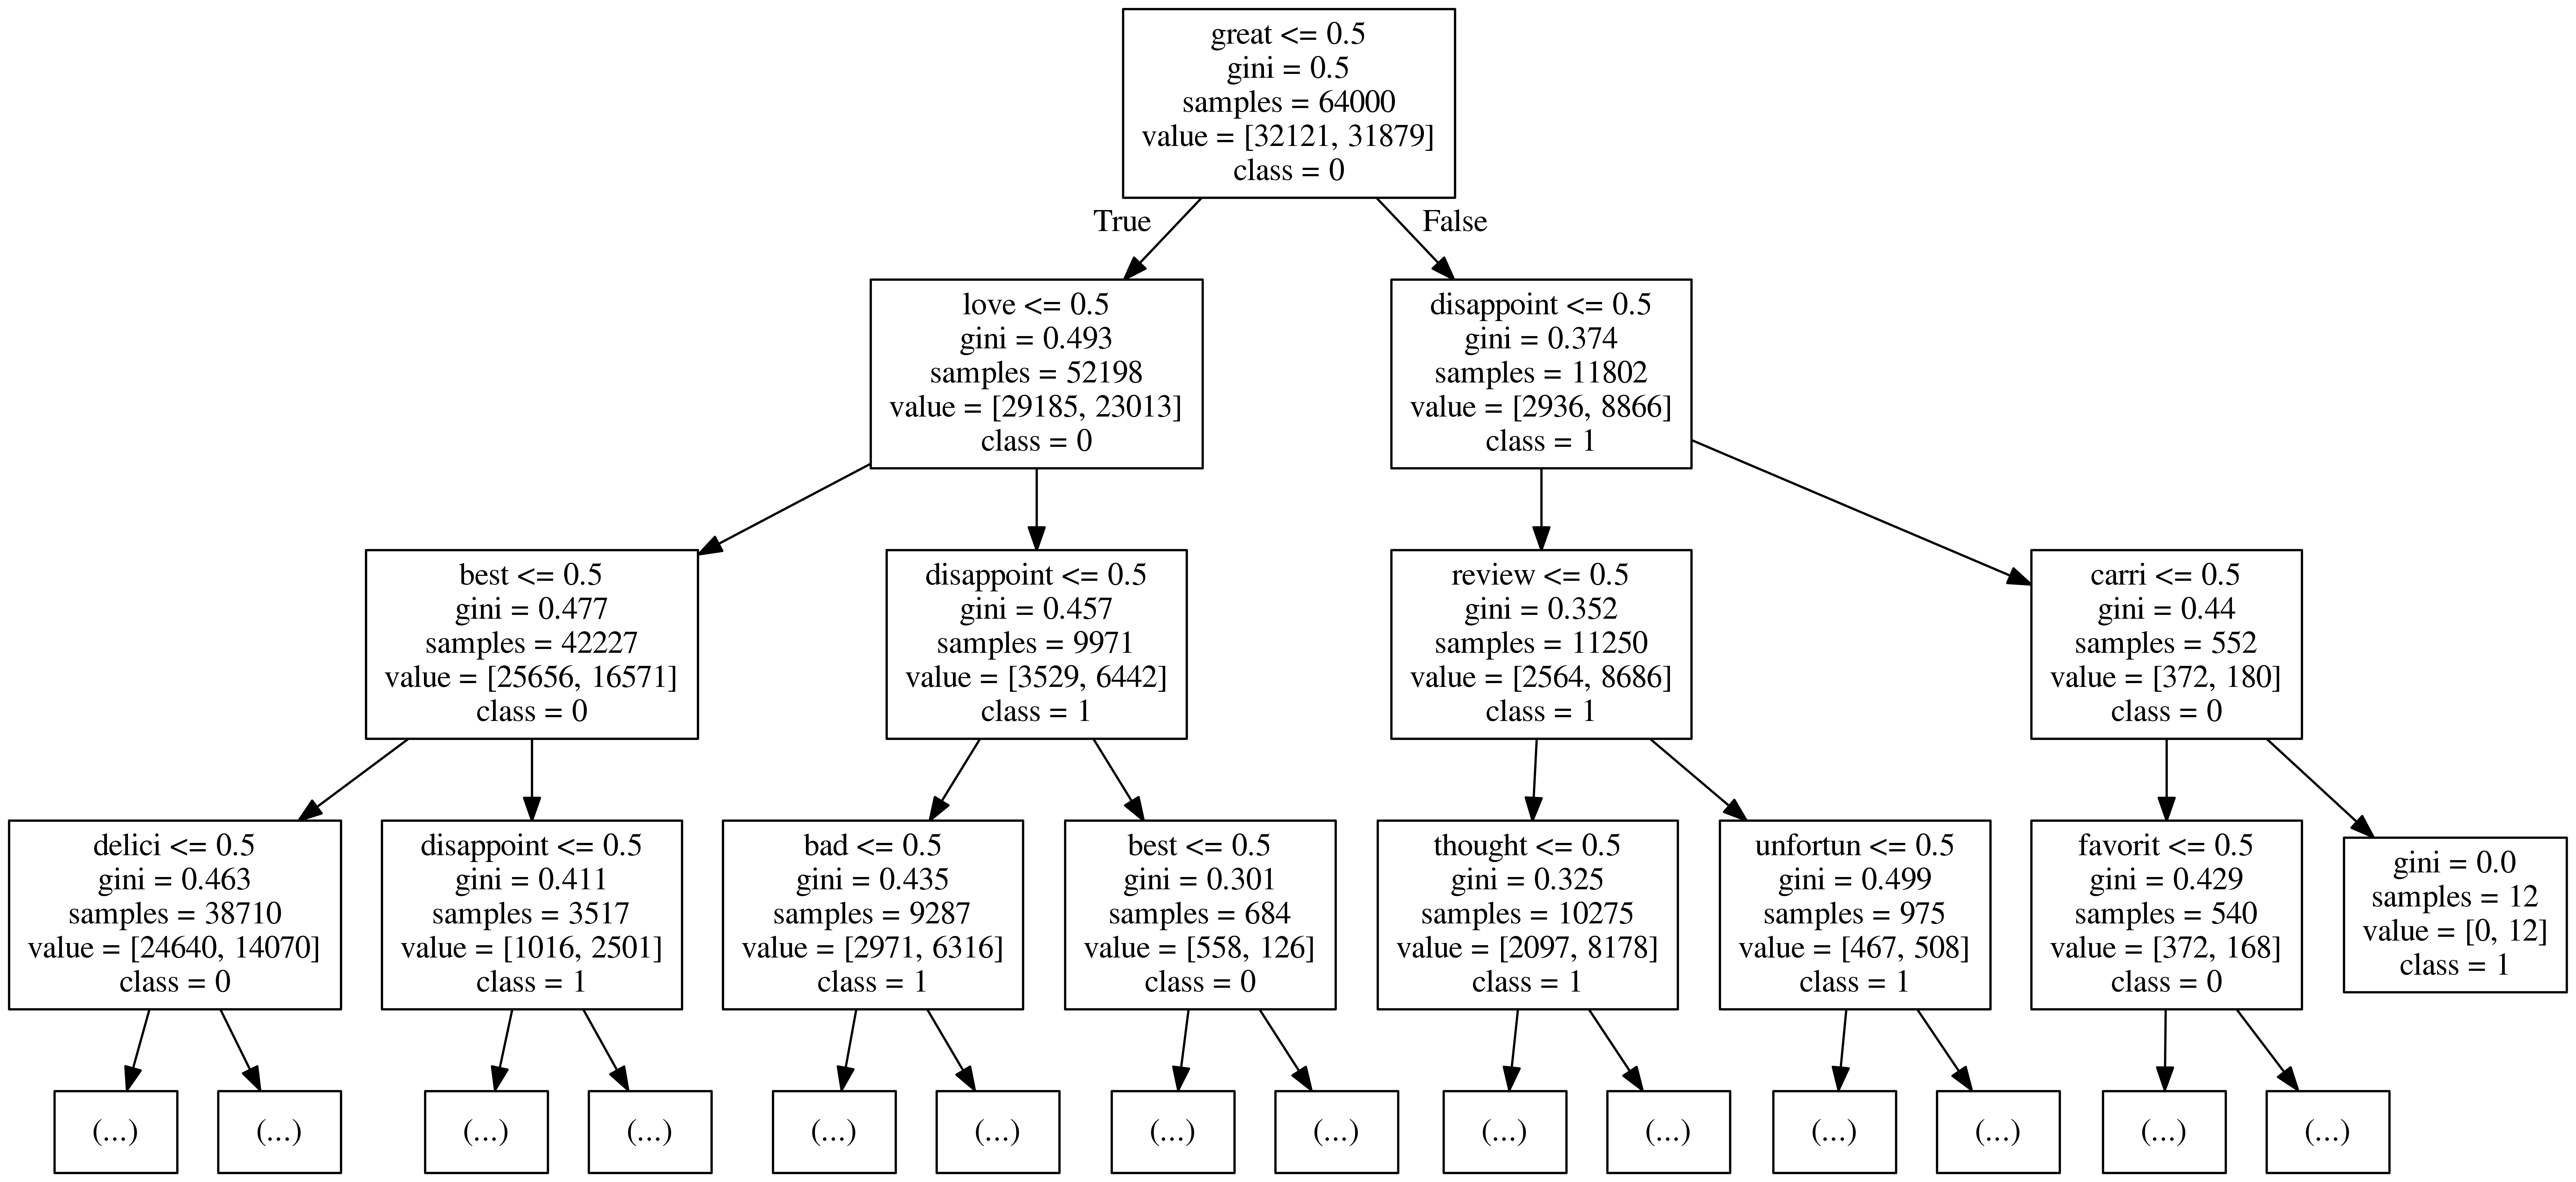

In [53]:
from sklearn.tree import export_graphviz
export_graphviz(clf,feature_names = names,max_depth=3,
                class_names = ['0','1'],out_file='tree.dot')
from subprocess import call
#converting from dot to png
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

**TF-IDF****

![](http://)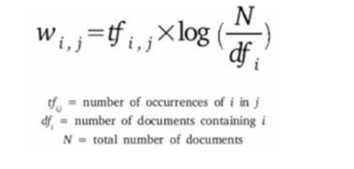

In [57]:
tfidf_words = TfidfVectorizer()
x_train_tfidf= tfidf_words.fit_transform(X_train)
x_test_tfidf= tfidf_words.transform(X_test)
x_cv_tfidf = tfidf_words.transform(X_cv)

print('After vectorizing shape of x Train',x_train_tfidf.shape)
print('After vectorizing shape of x Test',x_test_tfidf.shape)
print('After vectorizing shape of x CV',x_cv_tfidf.shape)


After vectorizing shape of x Train (64000, 31263)
After vectorizing shape of x Test (20000, 31263)
After vectorizing shape of x CV (16000, 31263)


The f1 score of cv data for depth  5 is 0.6285502410085279
The f1 score of cv data for depth  10 is 0.7276354341998629
The f1 score of cv data for depth  20 is 0.7515307766677408
The f1 score of cv data for depth  40 is 0.7532994923857869
The f1 score of cv data for depth  80 is 0.7460108879294162
The f1 score of cv data for depth  160 is 0.7423695029276193
The f1 score of cv data for depth  200 is 0.7412656968792739
The f1 score of cv data for depth  250 is 0.7385209644258924


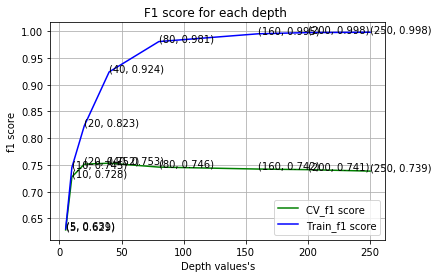

In [61]:
depth = [5,10,20,40,80,160,200,250]
decision_treegini(x_train_tfidf,Y_train,x_test_tfidf,Y_test,x_cv_tfidf,Y_cv,depth)

We can consider 15 as depth as from plot we can see there is not much difference between train and CV scores

For values of best depth =  15 The train f1  score is: 0.7801668119828252
For values of  best depth =  15 The test  f1 score is: 0.7344739182755193
Accuracy on train data is  0.791203125
Accuracy on test data is  0.74625
-------------------- Confusion matrix on train data --------------------


<Figure size 1440x504 with 0 Axes>

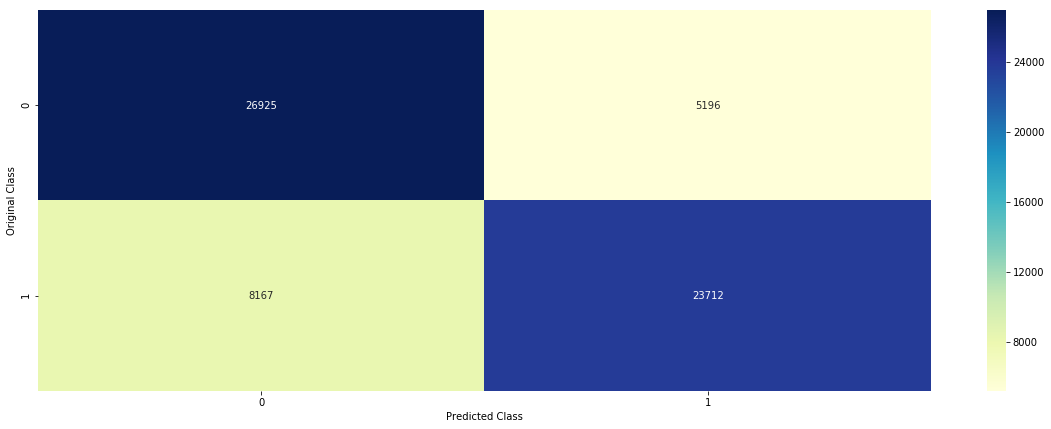

-------------------- Confusion matrix on test data --------------------


<Figure size 1440x504 with 0 Axes>

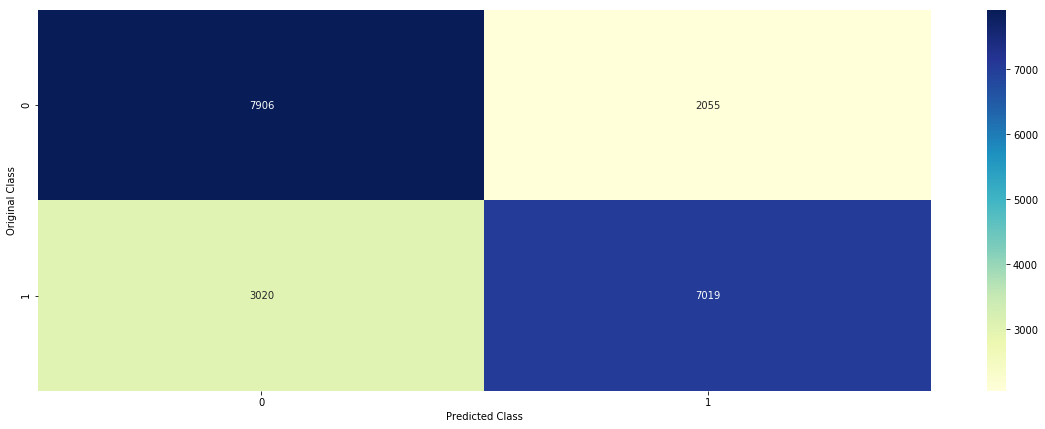

              precision    recall  f1-score   support

           0       0.72      0.79      0.76      9961
           1       0.77      0.70      0.73     10039

   micro avg       0.75      0.75      0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



In [78]:
acc_tfidf,best_depth_tfidf = best_model(x_train_tfidf,Y_train,x_test_tfidf,Y_test,x_cv_tfidf,Y_cv,15)

We can see best max_depth is 15 and accuracy on test_data is 73.44% and model is good as it is not underfit or over fit because there is not much diffrence in train and test accuracy

In [79]:
clf = DecisionTreeClassifier(max_depth =15)
clf.fit(x_train_tfidf,Y_train)
importances = clf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]
names = tfidf_words.get_feature_names()
names = np.array(names)
print('Top 25 important features',names[indices])


Top 25 important features ['great' 'love' 'disappoint' 'best' 'delici' 'perfect' 'good' 'excel'
 'bad' 'favorit' 'money' 'nice' 'tast' 'thought' 'tasti' 'amaz' 'easi'
 'would' 'unfortun' 'enjoy' 'aw' 'product' 'horribl' 'howev' 'wast']


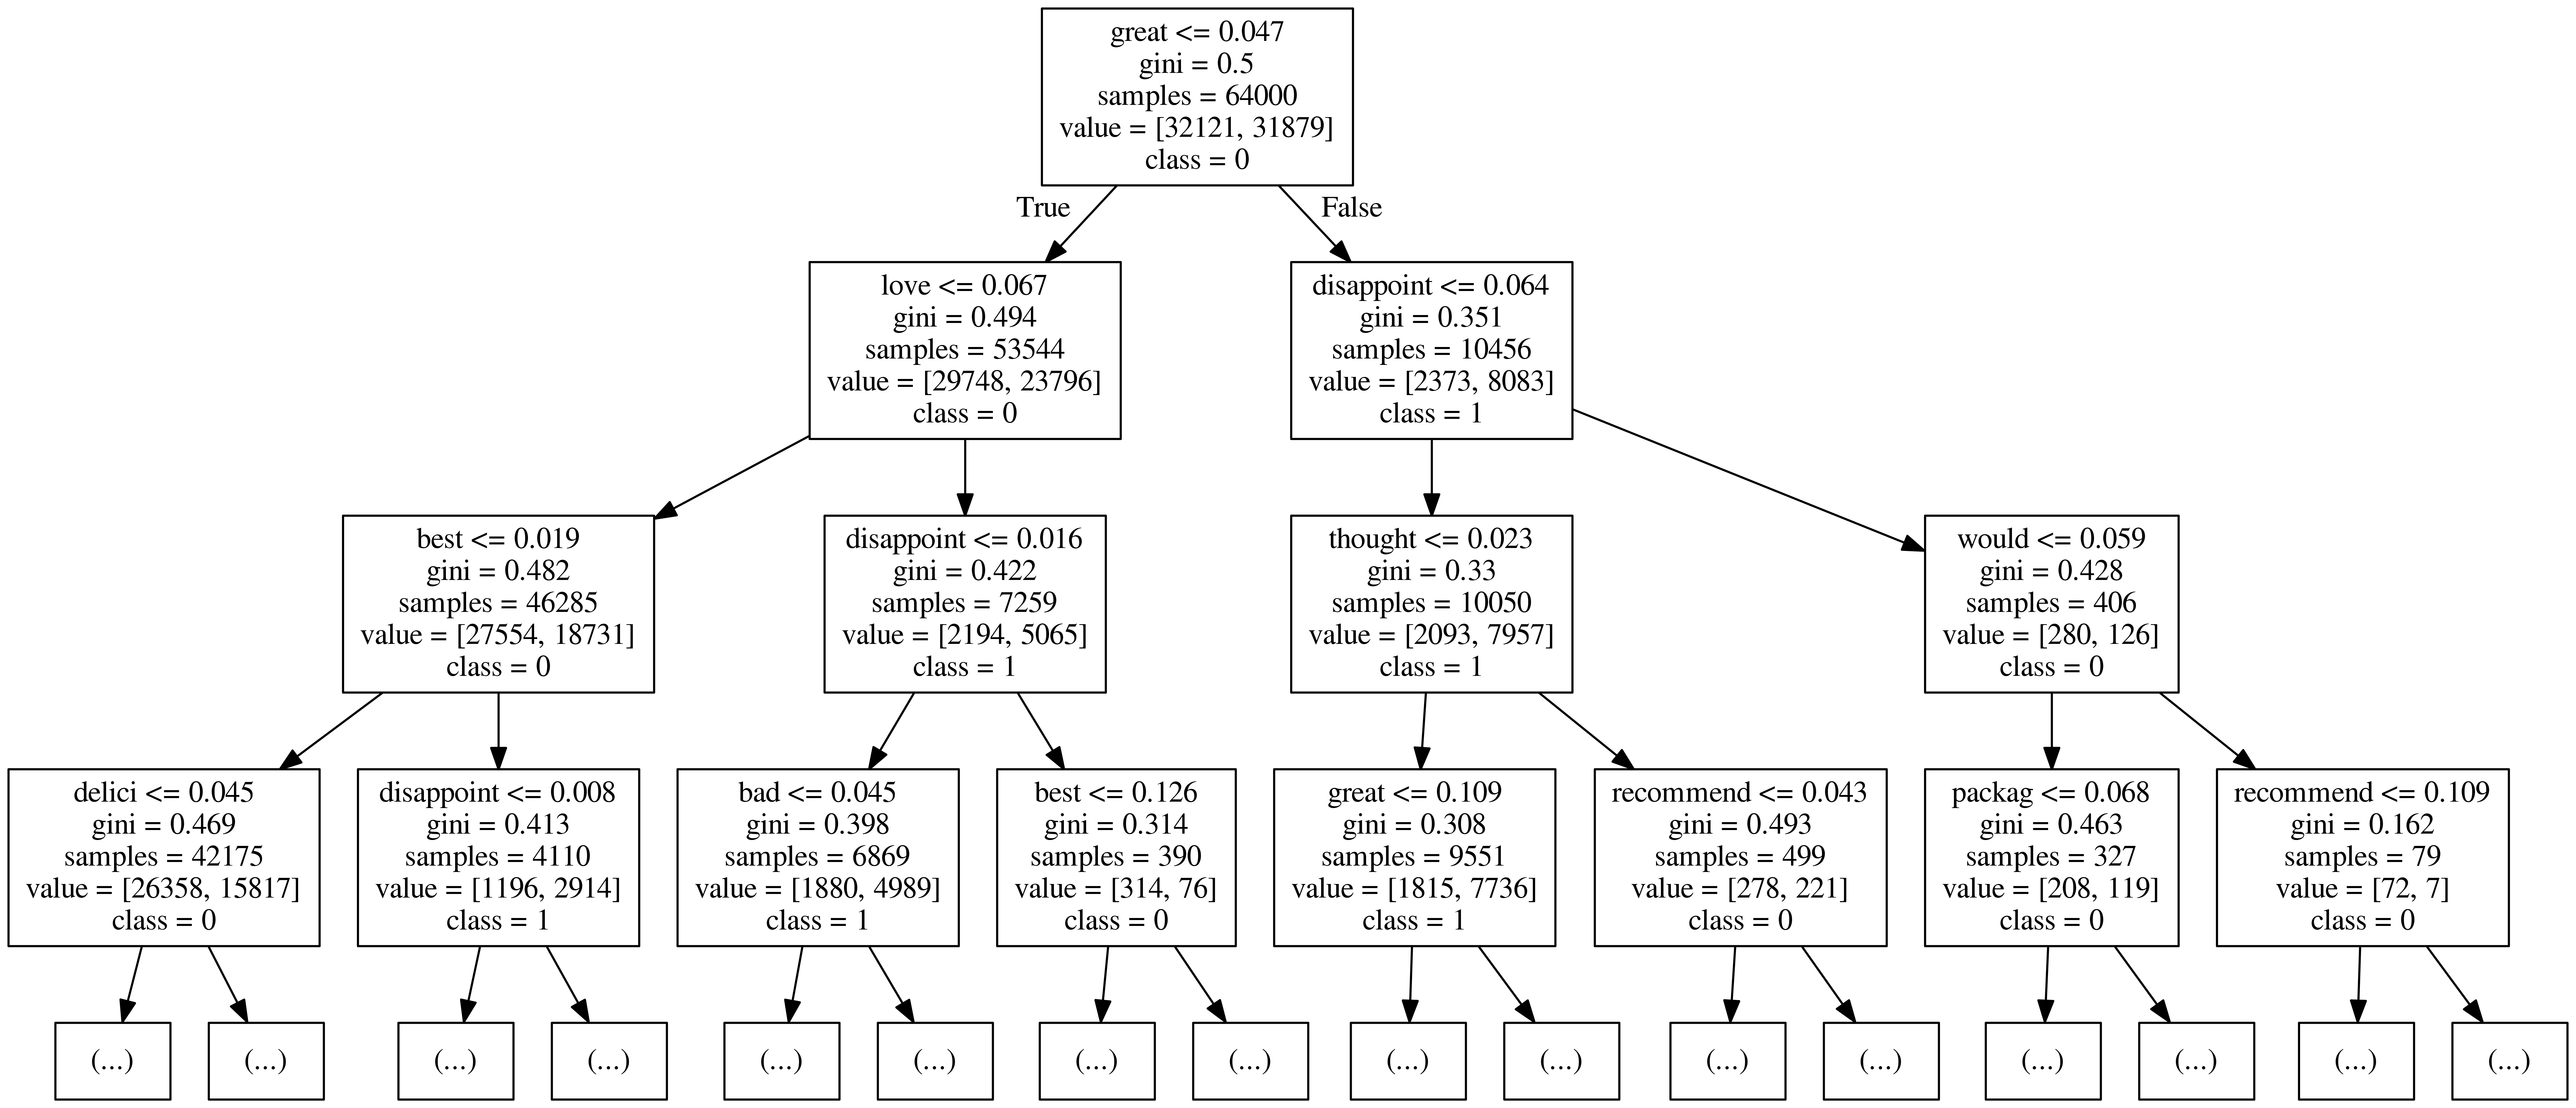

In [80]:
from sklearn.tree import export_graphviz
export_graphviz(clf,feature_names = names,max_depth=3,
                class_names = ['0','1'],out_file='tree.dot')
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

**Avg Word2Vec**
One of the most naive but good ways to convert a sentence into a vector
Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence

In [69]:
#AVG_word2vec training on our own vocaubulary
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
i=0
list_sent_train=[]
for sent in X_train:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=clean_html(sent)
    for w in sent.split():
        for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_train.append(filtered_sentence)

In [70]:
w2v_model=gensim.models.Word2Vec(list_sent_train,min_count=5,size=50, workers=4) 

In [71]:
x_train_avgw2v= []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    x_train_avgw2v.append(sent_vec)
print(len(x_train_avgw2v))
print(len(x_train_avgw2v[0]))

64000
50


In [72]:
list_sent_test=[]
for sent in X_test:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=clean_html(sent)
    for w in sent.split():
        for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_test.append(filtered_sentence)
x_test_avgw2v= []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    x_test_avgw2v.append(sent_vec)
print(len(x_test_avgw2v))
print(len(x_test_avgw2v[0]))

20000
50


In [73]:
list_sent_cv=[]
for sent in X_cv:
    filtered_sentence=[]
    sent = sent.decode('utf-8')
    sent=clean_html(sent)
    for w in sent.split():
        for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_cv.append(filtered_sentence)
x_cv_avgw2v= []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    x_cv_avgw2v.append(sent_vec)
print(len(x_cv_avgw2v))
print(len(x_cv_avgw2v[0]))

16000
50


The f1 score of cv data for depth  5 is 0.7365779002142638
The f1 score of cv data for depth  10 is 0.7672440553796486
The f1 score of cv data for depth  20 is 0.7314976326937453
The f1 score of cv data for depth  40 is 0.7286589176352957
The f1 score of cv data for depth  80 is 0.7273747195213164
The f1 score of cv data for depth  160 is 0.728262910798122
The f1 score of cv data for depth  200 is 0.7279540344741443
The f1 score of cv data for depth  250 is 0.7313609467455622
The f1 score of cv data for depth  300 is 0.7301983285518274


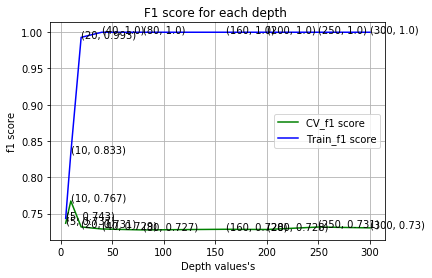

In [74]:
depth = [5,10,20,40,80,160,200,250,300]
decision_treegini(x_train_avgw2v,Y_train,x_test_avgw2v,Y_test,x_cv_avgw2v,Y_cv,depth)


By seeing above figure we can say 5 is the best depth as train and CV scores are near

For values of best depth =  5 The train f1  score is: 0.7433011378468436
For values of  best depth =  5 The test  f1 score is: 0.7380777696258254
Accuracy on train data is  0.738796875
Accuracy on test data is  0.73225
-------------------- Confusion matrix on train data --------------------


<Figure size 1440x504 with 0 Axes>

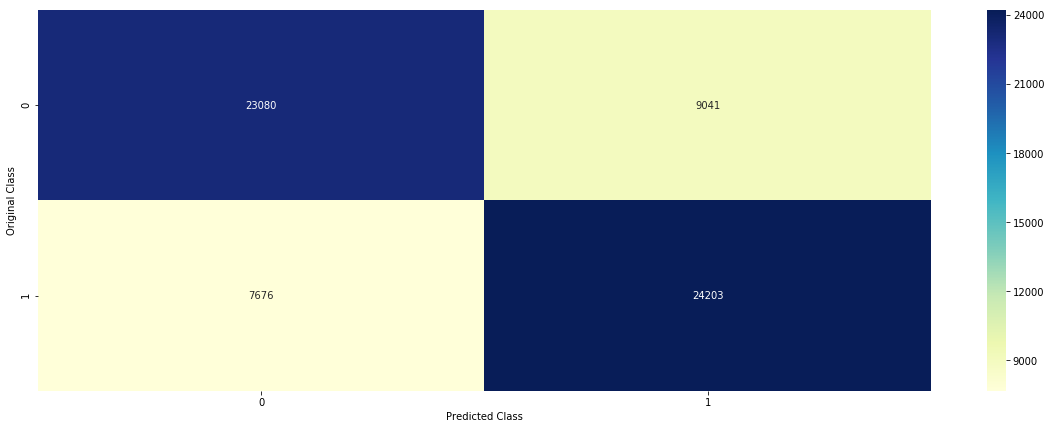

-------------------- Confusion matrix on test data --------------------


<Figure size 1440x504 with 0 Axes>

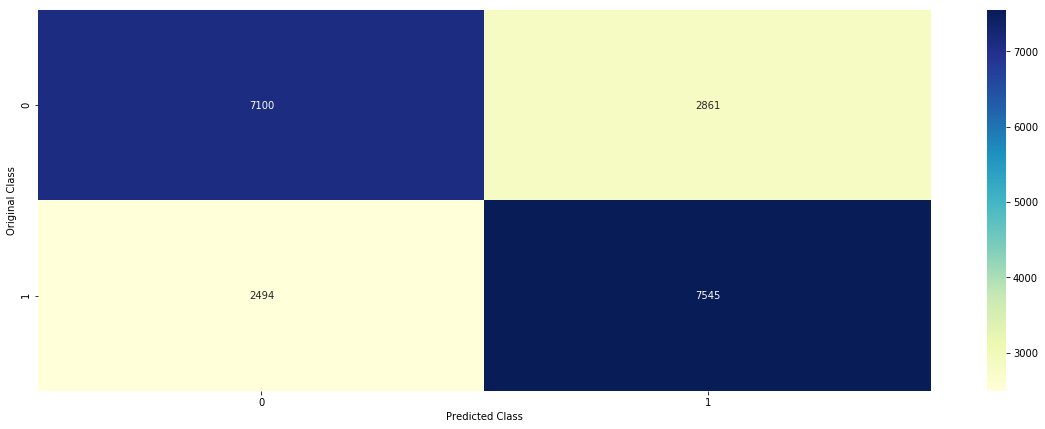

              precision    recall  f1-score   support

           0       0.74      0.71      0.73      9961
           1       0.73      0.75      0.74     10039

   micro avg       0.73      0.73      0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000



In [106]:
acc_avgw2v,best_depth_avgw2v = best_model(x_train_avgw2v,Y_train,x_test_avgw2v,Y_test,x_cv_avgw2v,Y_cv,5)

We can see best max_depth is 05 and accuracy on test_data is 73.22% and model is good as it is not underfit or over fit because there is not much diffrence in train and test accuracy . In word2vec we cannot get the important features.Lets print the tree , also we cannot get the feature names 

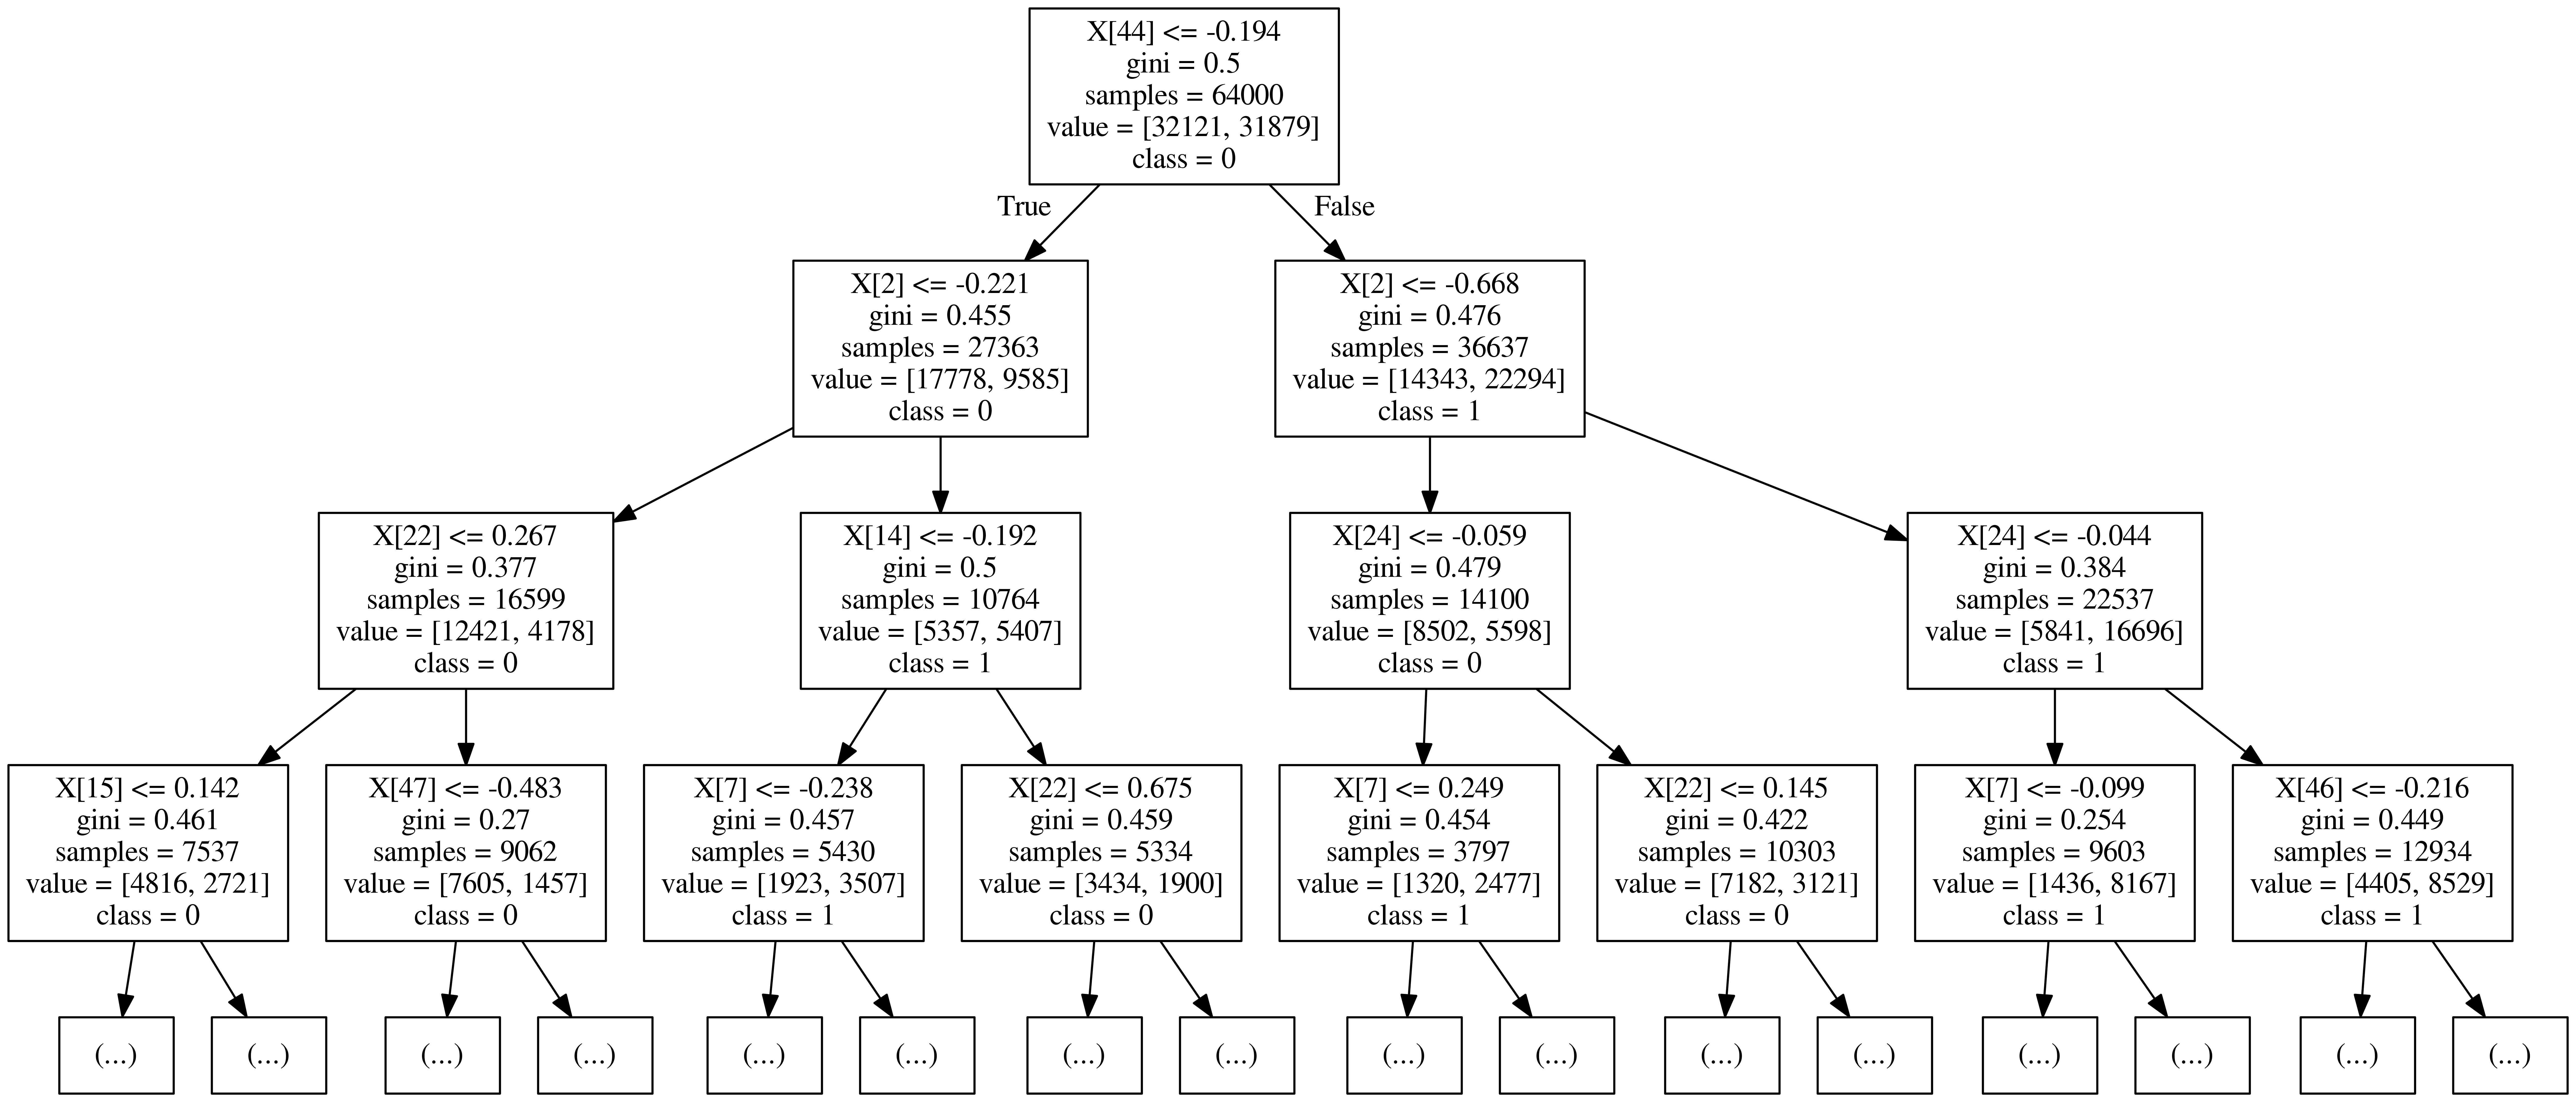

In [90]:
from sklearn.tree import export_graphviz
clf = DecisionTreeClassifier(max_depth =5)
clf.fit(x_train_avgw2v,Y_train)
export_graphviz(clf,max_depth=3,
                class_names = ['0','1'],out_file='tree.dot')
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

**Tf-idf W2Vec**
Another way to covert sentence into vectors
Take weighted sum of the vectors divided by the sum of all the tfidf's 
i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [82]:
tfidf_feat = tfidf_words.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

x_train_tfidfwv= []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    x_train_tfidfwv.append(sent_vec)
    row += 1
print('train shape',len(x_train_tfidfwv),len(x_train_tfidfwv[0]))


train shape 64000 50


In [83]:
x_test_tfidfwv= []
for sent in list_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    x_test_tfidfwv.append(sent_vec)
    row += 1
print('test shape',len(x_test_tfidfwv),len(x_test_tfidfwv[0]))

test shape 20000 50


In [84]:
x_cv_tfidfwv= []
for sent in list_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    x_cv_tfidfwv.append(sent_vec)
    row += 1
print('test shape',len(x_cv_tfidfwv),len(x_cv_tfidfwv[0]))


test shape 16000 50


In [85]:
x_train_tfidfwv = np.nan_to_num(x_train_tfidfwv)
x_test_tfidfwv = np.nan_to_num(x_test_tfidfwv)
x_cv_tfidfwv = np.nan_to_num(x_cv_tfidfwv)

The f1 score of cv data for depth  5 is 0.0
The f1 score of cv data for depth  10 is 0.0
The f1 score of cv data for depth  20 is 0.0
The f1 score of cv data for depth  30 is 0.0
The f1 score of cv data for depth  40 is 0.0
The f1 score of cv data for depth  80 is 0.0
The f1 score of cv data for depth  150 is 0.0
The f1 score of cv data for depth  200 is 0.0
The f1 score of cv data for depth  250 is 0.0
The f1 score of cv data for depth  300 is 0.0


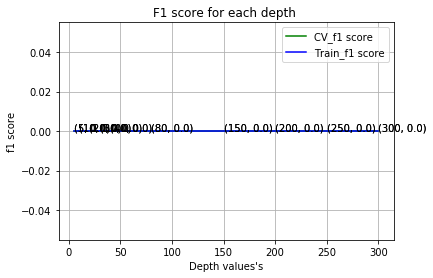

In [87]:
depth = [5,10,20,30,40,80,150,200,250,300]
decision_treegini(x_train_tfidfwv,Y_train,x_test_tfidfwv,Y_test,x_cv_tfidfwv,Y_cv,depth)



For values of best depth =  10 The train f1  score is: 0.0
For values of  best depth =  10 The test  f1 score is: 0.0
Accuracy on train data is  0.501890625
Accuracy on test data is  0.49805
-------------------- Confusion matrix on train data --------------------


<Figure size 1440x504 with 0 Axes>

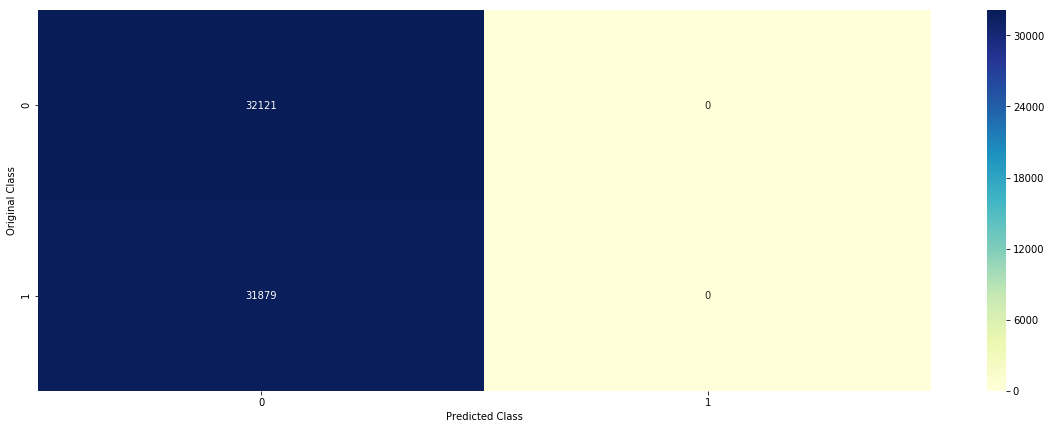

-------------------- Confusion matrix on test data --------------------


<Figure size 1440x504 with 0 Axes>

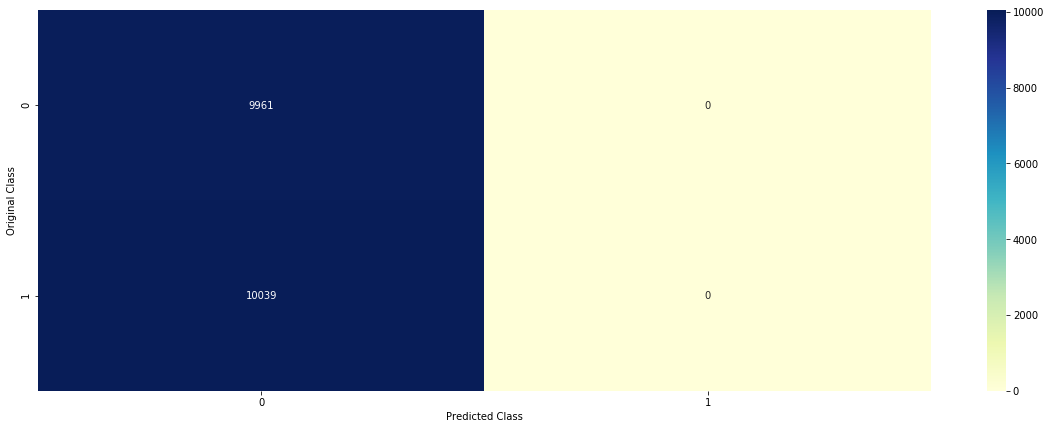

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      9961
           1       0.00      0.00      0.00     10039

   micro avg       0.50      0.50      0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



In [102]:

acc_tfidfwv,best_depth_tfidfwv = best_model(x_train_tfidfwv,Y_train,x_test_tfidfwv,Y_test,x_cv_tfidfwv,Y_cv,10)


The tfidf_w2v model is looks like dumb model because it is biased towards majority class, as classifier predicted all points as -ve class.


In [103]:
from IPython.display import HTML, display
import tabulate
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [107]:
table = [['NLP Technique','Best_Max_depth','Accuracy'],
         ['Bag of Words',best_depth,acc_bag],
         ['TF IDF ',best_depth_tfidf,acc_tfidf],
         ['Avg word2vec',best_depth_avgw2v,acc_avgw2v]
        ]

In [108]:
display(HTML(tabulate.tabulate(table, tablefmt='html')))

NLP Technique,Best_Max_depth,Accuracy
Bag of Words,10,0.73135
TF IDF,15,0.74625
Avg word2vec,5,0.73225


**Performance Table**

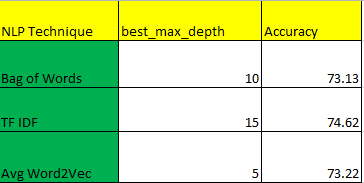

**conclusion**:
We can see different depths and accuracy for different technique as TfIDf word2vec is performing worst we ddnt include in the above table